## Setup

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model

import copy as cp

In [25]:
def load_data(test=False):
    X_raw = Y_raw = None
    segment = False

    if test:
        X_raw = np.load("../emulator/hc_test_G3.npy", allow_pickle=True)
        Y_raw = np.load("../emulator/samples_test_G3.npy", allow_pickle=True)
    else:
        X_raw = np.load("../emulator/hc_G3_redo.npy", allow_pickle=True)
        Y_raw = np.load("../emulator/samples_G3_redo.npy", allow_pickle=True)
    
    scales = np.load("../emulator/standard_k.npy", allow_pickle=True)
    
    return scales, X_raw, Y_raw

In [8]:
def eliminate_holes(X_raw, Y_raw):
    def is_bad(row):
        if float('-inf') in row or float('inf') in row \
            or None in row or True in np.isnan(pspec) \
            or 0 in row:
            return True
        return False

    bad_row_indices = []
    for i in range(len(Y_raw)):
        pspec = Y_raw[i]
        if is_bad(pspec):
            bad_row_indices.append(i)

    X = np.delete(X_raw, bad_row_indices, 0)
    Y = np.delete(Y_raw, bad_row_indices, 0)
    
    return X, Y

In [60]:
def normalize_data(Y):
    Ylog = np.log(Y)
    mu = np.mean(Ylog, axis=0)
    stdev = np.std(Ylog, axis=0)
    
    Y_normalized = cp.deepcopy(Ylog)

    for i in range(len(Y)):
        Y_normalized[i] -= mu
        Y_normalized[i] /= stdev
        
    return mu, stdev, Y_normalized

In [62]:
def inverse_transform(mu, stdev, raw_prediction):
    return np.exp(raw_prediction * stdev + mu)

## Prepare the data

In [61]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
k, raw_train_x, raw_train_y = load_data(test=False)

# Normalize and reshape the data
consolidated_train_x, consolidated_train_y = \
    eliminate_holes(raw_train_x, raw_train_y)

train_mu, train_std, normalized_train_y = \
    normalize_data(consolidated_train_y)

k, raw_test_x, raw_test_y = load_data(test=True)

# Normalize and reshape the data
consolidated_test_x, consolidated_test_y = \
    eliminate_holes(raw_test_x, raw_test_y)

test_mu, test_std, normalized_test_y = \
    normalize_data(consolidated_test_y)

## Build the FCNN

In [135]:
input_layer = layers.Input(shape=(6))

# Encoder
#x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
# x = layers.MaxPooling2D((3, 3), padding="same")(x)
#x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((3, 3), padding="same")(x)

x = layers.Dense(64, activation='relu')(input_layer)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(300, activation='softmax')(x)

# Decoder
#x = layers.Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
#x = layers.Conv2DTranspose(64, (3, 3), strides=1, activation="relu", padding="same")(x)
#x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Emulator
emu = Model(input_layer, x)
emu.compile(optimizer="adam", loss="mean_squared_error")
emu.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 6)]               0         
                                                                 
 dense_52 (Dense)            (None, 64)                448       
                                                                 
 dense_53 (Dense)            (None, 128)               8320      
                                                                 
 dense_54 (Dense)            (None, 256)               33024     
                                                                 
 dense_55 (Dense)            (None, 256)               65792     
                                                                 
 dense_56 (Dense)            (None, 256)               65792     
                                                                 
 dense_57 (Dense)            (None, 256)               657

## Training and testing

In [136]:
emu.fit(
    x=consolidated_train_x,
    y=normalized_train_y,
    epochs=10,
    batch_size=32, # we've got to play around with this
    shuffle=True,
    validation_data=(consolidated_test_x, normalized_test_y),
)
# predictions = emu.predict(test_data)

Epoch 1/10
157/157 [==============================] - 2s 7ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 0.9999 - val_loss: 0.9998
Epoch 3/10
157/157 [==============================] - 1s 7ms/step - loss: 0.9997 - val_loss: 0.9996
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 0.9999 - val_loss: 1.0001
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.9997 - val_loss: 0.9992
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.9992 - val_loss: 1.0001
Epoch 7/10
157/157 [==============================] - 1s 6ms/step - loss: 0.9996 - val_loss: 0.9983
Epoch 8/10
157/157 [==============================] - 1s 7ms/step - loss: 0.9985 - val_loss: 0.9982
Epoch 9/10
157/157 [==============================] - 1s 7ms/step - loss: 0.9983 - val_loss: 0.9982
Epoch 10/10
157/157 [==============================] - 1s 7ms/step - loss: 0.9983 - val_loss: 0.9982

In [137]:
consolidated_train_x[0].shape

(6,)

first_prediction = emu.predict(consolidated_train_x[0])
plt.loglog(k, first_prediction)

In [138]:
predictions = emu.predict(consolidated_test_x)

157/157 [==============================] - 0s 1ms/step


In [139]:
predictions.shape

(5000, 300)

215098399692.45816


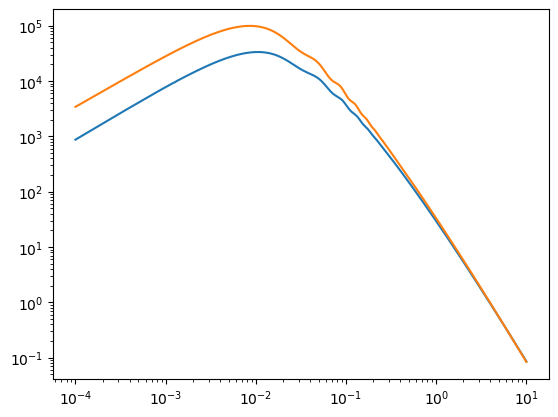

In [140]:
test_index = 0
pred = inverse_transform(train_mu, train_std, predictions[test_index])
actual = inverse_transform(train_mu, train_std, normalized_test_y[test_index])

plt.loglog(k, pred)
plt.loglog(k, actual)

print(sum((pred - actual) ** 2))

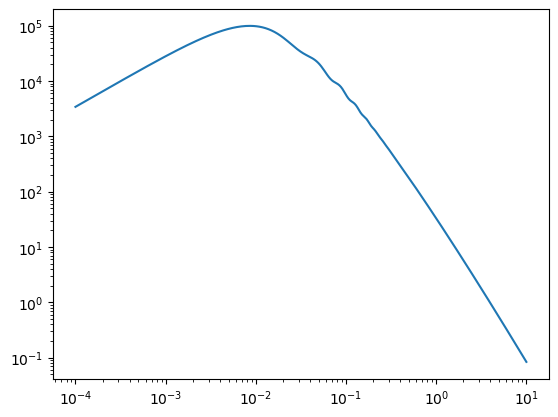

In [141]:
plt.loglog(k, inverse_transform(train_mu, train_std, normalized_test_y[0]))